<a href="https://colab.research.google.com/github/sakshishri86/Loan-Recovery-System/blob/main/Loan_Recovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTING LIBRARIES


In [16]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('loan-recovery.csv')

conn = sqlite3.connect('loan_recovery.db')
df.to_sql('loans', conn, if_exists='replace', index=False)

print("Data loaded into SQL database successfully!")
print("Total Records:", len(df))
df.head()

Data loaded into SQL database successfully!
Total Records: 500


,Borrower_ID,Age,Gender,Employment_Type,Monthly_Income,Num_Dependents,Loan_ID,Loan_Amount,Loan_Tenure,Interest_Rate,...,Collateral_Value,Outstanding_Loan_Amount,Monthly_EMI,Payment_History,Num_Missed_Payments,Days_Past_Due,Recovery_Status,Collection_Attempts,Collection_Method,Legal_Action_Taken
0,BRW_1,59,Male,Salaried,215422,0,LN_1,1445796,60,12.39,...,1.727997e+06,2.914130e+05,4856.88,On-Time,0,0,Partially Recovered,1,Settlement Offer,No
1,BRW_2,49,Female,Salaried,60893,0,LN_2,1044620,12,13.47,...,1.180032e+06,6.652042e+05,55433.68,On-Time,0,0,Fully Recovered,2,Settlement Offer,No
2,BRW_3,35,Male,Salaried,116520,1,LN_3,1923410,72,7.74,...,2.622540e+06,1.031372e+06,14324.61,Delayed,2,124,Fully Recovered,2,Legal Notice,No
3,BRW_4,63,Female,Salaried,140818,2,LN_4,1811663,36,12.23,...,1.145493e+06,2.249739e+05,6249.28,On-Time,1,56,Fully Recovered,2,Calls,No
4,BRW_5,28,Male,Salaried,76272,1,LN_5,88578,48,16.13,...,0.000000e+00,3.918989e+04,816.46,On-Time,1,69,Fully Recovered,0,Debt Collectors,No


SOLUTION-1 : Identify borrower segments based on attributes such as loan amount, monthly income, payment history, and missed payments.

In [17]:
query_segmentation = """
WITH Segments AS (
    SELECT
        Borrower_ID,
        Monthly_Income,
        Num_Missed_Payments,
        Loan_Amount,
        CASE
            WHEN Monthly_Income < 50000 THEN 'Low Income'
            WHEN Monthly_Income >= 50000 AND Monthly_Income < 150000 THEN 'Medium Income'
            ELSE 'High Income'
        END AS income_segment,
        CASE
            WHEN Num_Missed_Payments >= 5 THEN 'High Risk Payer'
            WHEN Num_Missed_Payments >= 2 AND Num_Missed_Payments < 5 THEN 'Medium Risk Payer'
            ELSE 'Low Risk Payer'
        END AS payment_risk_segment
    FROM loans
)
SELECT
    income_segment,
    payment_risk_segment,
    COUNT(Borrower_ID) as num_borrowers,
    AVG(Loan_Amount) as avg_loan_amount
FROM Segments
GROUP BY income_segment, payment_risk_segment
ORDER BY num_borrowers DESC;
"""

df_segments = pd.read_sql_query(query_segmentation, conn)
print("Borrower Segments Analysis")
print(df_segments)

Borrower Segments Analysis
  income_segment payment_risk_segment  num_borrowers  avg_loan_amount
0    High Income       Low Risk Payer            104     1.045938e+06
1    High Income    Medium Risk Payer            102     9.364578e+05
2  Medium Income       Low Risk Payer             98     1.042523e+06
3  Medium Income    Medium Risk Payer             98     1.122731e+06
4     Low Income       Low Risk Payer             40     9.371958e+05
5     Low Income    Medium Risk Payer             31     1.008526e+06
6  Medium Income      High Risk Payer             13     1.080036e+06
7    High Income      High Risk Payer             12     9.651333e+05
8     Low Income      High Risk Payer              2     7.941165e+05


SOLUTION-2 : Optimize collection methods to increase recovery rates.

In [18]:
query_optimization = """
SELECT
    Collection_Method,
    COUNT(Loan_ID) AS total_cases,
    SUM(CASE WHEN Recovery_Status = 'Fully Recovered' THEN 1 ELSE 0 END) AS successful_recoveries,
    ROUND(
        SUM(CASE WHEN Recovery_Status = 'Fully Recovered' THEN 1 ELSE 0 END) * 100.0 / COUNT(Loan_ID), 2
    ) AS success_rate_percent
FROM loans
WHERE Recovery_Status != 'Written Off'
GROUP BY Collection_Method
ORDER BY success_rate_percent DESC;
"""

df_optimization = pd.read_sql_query(query_optimization, conn)
print("Collection Method Effectiveness ")
print(df_optimization)

Collection Method Effectiveness 
  Collection_Method  total_cases  successful_recoveries  success_rate_percent
0  Settlement Offer          105                     72                 68.57
1             Calls          116                     77                 66.38
2      Legal Notice          116                     76                 65.52
3   Debt Collectors          113                     71                 62.83


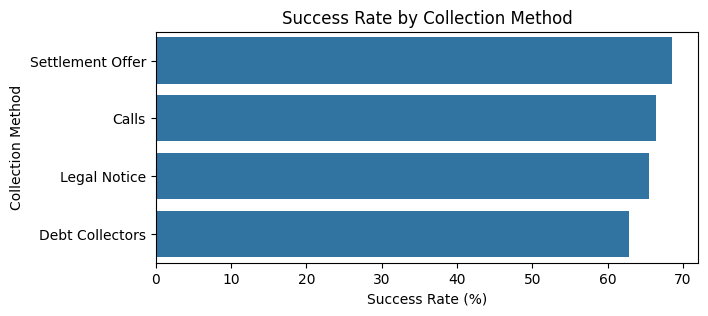

In [27]:
plt.figure(figsize=(7,3))
sns.barplot(data=df_optimization, x='success_rate_percent', y='Collection_Method')
plt.title('Success Rate by Collection Method')
plt.xlabel('Success Rate (%)')
plt.ylabel('Collection Method')
plt.show()

SOLUTION-4: Minimize recovery costs while maximizing the amount recovered.

In [20]:
 #SIMULATING RECOVERY COSTS

cost_mapping = {
    'Calls': 50,              # Phone calls are cheapest
    'Legal Notice': 250,      # Sending a notice has some legal cost
    'Settlement Offer': 100,  # Administrative cost for offer
    'Debt Collectors': 1000   # Agencies take a significant commission/fee
}


df['Recovery_Cost'] = df['Collection_Method'].map(cost_mapping)


df.to_sql('loans', conn, if_exists='replace', index=False)

print("'Recovery_Cost' column added and database updated successfully!")
df[['Collection_Method', 'Recovery_Cost']].head()

'Recovery_Cost' column added and database updated successfully!


,Collection_Method,Recovery_Cost
0,Settlement Offer,100
1,Settlement Offer,100
2,Legal Notice,250
3,Calls,50
4,Debt Collectors,1000


In [21]:
#ANALYSIS FOR ROI
query_cost_optimization = """
SELECT
    Collection_Method,
    SUM(Recovery_Cost) AS total_cost,
    SUM(CASE WHEN Recovery_Status = 'Fully Recovered' THEN Loan_Amount ELSE 0 END) AS total_amount_recovered,
    -- ROI Calculation: (Total Recovered / Total Cost)
    ROUND(
        SUM(CASE WHEN Recovery_Status = 'Fully Recovered' THEN Loan_Amount ELSE 0 END) / SUM(Recovery_Cost), 2
    ) AS return_on_investment
FROM loans
WHERE Collection_Method IS NOT NULL
GROUP BY Collection_Method
ORDER BY return_on_investment DESC;
"""
df_roi = pd.read_sql_query(query_cost_optimization, conn)
print("Cost-Effectiveness (ROI) of Collection Methods ")
print(df_roi)

Cost-Effectiveness (ROI) of Collection Methods 
  Collection_Method  total_cost  total_amount_recovered  return_on_investment
0             Calls        6450                77065959               11948.0
1  Settlement Offer       12000                70899341                5908.0
2      Legal Notice       31500                88113776                2797.0
3   Debt Collectors      125000                72384196                 579.0


/tmp/ipython-input-765022045.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_roi, y='Collection_Method', x='return_on_investment', palette='viridis')


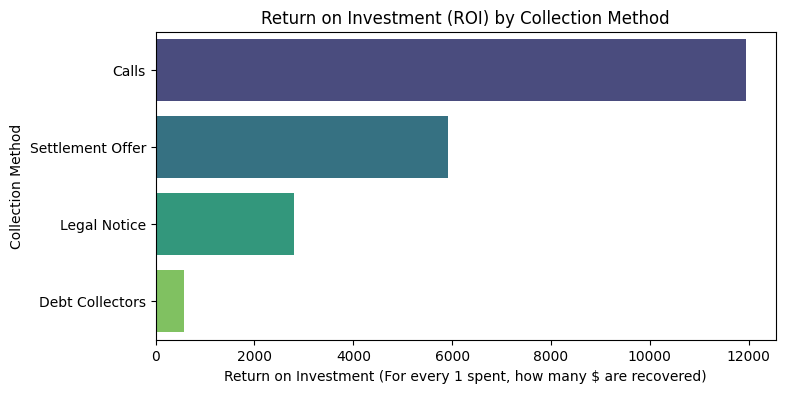

In [22]:
plt.figure(figsize=(8, 4))
sns.barplot(data=df_roi, y='Collection_Method', x='return_on_investment', palette='viridis')
plt.title('Return on Investment (ROI) by Collection Method')
plt.xlabel('Return on Investment (For every 1 spent, how many $ are recovered)')
plt.ylabel('Collection Method')
plt.show()

SOLUTION-5:Develop an early warning system to flag borrowers who are at high risk of default.

In [23]:
query_early_warning = """
SELECT
    Borrower_ID,
    Num_Missed_Payments,
    Days_Past_Due,
    Outstanding_Loan_Amount,
    -- Risk Score Calculation (Higher is riskier)
    (Num_Missed_Payments * 15) + (Days_Past_Due / 10) + (Outstanding_Loan_Amount / 10000) AS risk_score
FROM loans
WHERE Recovery_Status NOT IN ('Fully Recovered', 'Partially Recovered')
ORDER BY risk_score DESC
LIMIT 10;
"""
df_early_warning = pd.read_sql_query(query_early_warning, conn)
print(" Early Warning System: Top 10 High-Risk Borrowers")
print(df_early_warning)

 Early Warning System: Top 10 High-Risk Borrowers
  Borrower_ID  Num_Missed_Payments  Days_Past_Due  Outstanding_Loan_Amount  \
0     BRW_155                    3            133             1.405426e+06   
1     BRW_237                   11             94             2.140124e+05   
2     BRW_233                    2             78             1.559717e+06   
3     BRW_427                    1             78             1.529736e+06   
4     BRW_310                    3              3             1.259501e+06   
5     BRW_105                    3            147             1.015521e+06   
6     BRW_134                    3            169             7.870265e+05   
7      BRW_13                    1              7             1.152937e+06   
8     BRW_486                    3             26             7.309815e+05   
9      BRW_71                    0              0             1.138871e+06   

   risk_score  
0  198.542603  
1  195.401240  
2  192.971706  
3  174.973628  
4  170.9501